In [235]:
# Implementation of matplotlib function
import cv2
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import time as t



### Aplicar um filtro gaussiano para remover possíveis ruídos da imagem

In [236]:
ddepth = cv2.CV_16UC1
scale = 1
delta = 0
alpha = 2
beta = 50


#image = cv2.imread("image5.png", cv2.IMREAD_COLOR)
image = cv2.imread("image2.jpg", cv2.IMREAD_COLOR)
#image = cv2.imread("image6.jpg", cv2.IMREAD_COLOR)
#image = cv2.imread("image7.jfif", cv2.IMREAD_COLOR)
#image = cv2.imread("image8.jpg", cv2.IMREAD_COLOR)
#image = cv2.imread("image10.jpg", cv2.IMREAD_COLOR)


#(r, g, b) = image(0,0)
#print("Red - {} | Green - {} | Blue - {}".format(r, g, b))
#print(image(0,0)[0])
(altura, largura) = image.shape[:2]
print("Altura da imagem: {} | Largura da imagem: {}".format(altura, largura))






 

Altura da imagem: 435 | Largura da imagem: 474


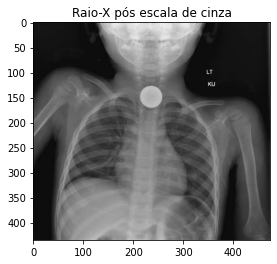

In [237]:
grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #Converte para escala de cinza
plt.gray()
plt.imshow(grayImage)
plt.title("Raio-X pós escala de cinza")
plt.show()

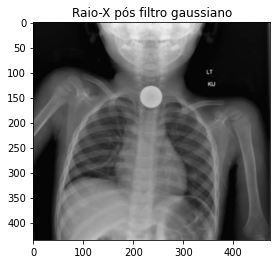

In [238]:
imageGauss = cv2.GaussianBlur(grayImage, (3, 3), 0)
#cv2.imshow("imageGray", image)
#cv2.waitKey(0) # waits until a key is pressed
#cv2.destroyAllWindows() # destroys the window showing image

plt.imshow(imageGauss)
plt.title('Raio-X pós filtro gaussiano')
plt.show()

### Ajuste de brilho e contraste


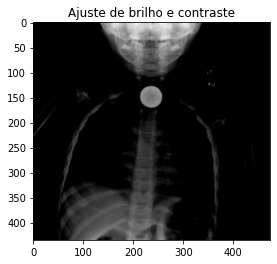

In [239]:
#brightness = -150 # brilho inicial
brightness = -100 # brilho inicial
contrast = 50 # contraste inicial
shadow = 0
highlight = 255 + brightness

alpha_b = (highlight - shadow)/255
gamma_b = shadow

procImage = cv2.addWeighted(imageGauss, alpha_b, imageGauss, 0, gamma_b)

f = 131*(contrast + 127)/(127*(131-contrast))
alpha_c = f
gamma_c = 127*(1-f)

procImage = cv2.addWeighted(procImage, alpha_c, procImage, 0, gamma_c)

plt.imshow(procImage)
plt.title('Ajuste de brilho e contraste')
plt.show()






### Gradiente X

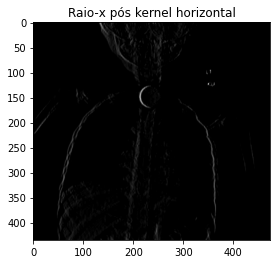

In [240]:
grad_x = cv2.Sobel(procImage, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
#grad_x = cv2.Sobel(procImage, ddepth, dx=1, dy=0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_CONSTANT)
plt.imshow(grad_x)
plt.title("Raio-x pós kernel horizontal")
plt.show()

### Gradiente Y

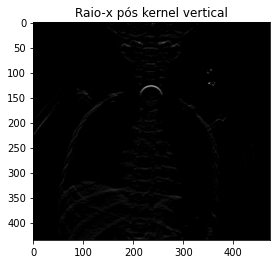

In [241]:
grad_y = cv2.Sobel(procImage, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
#grad_y = cv2.Sobel(procImage, ddepth, 1, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_CONSTANT)

plt.imshow(grad_y)
plt.title("Raio-x pós kernel vertical")
plt.show()

### Conjugação dos resultados dos gradientes

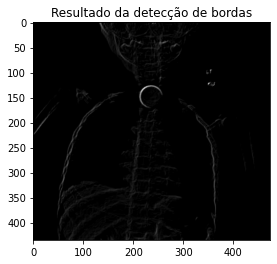

In [242]:
abs_grad_x = cv2.convertScaleAbs(grad_x)
abs_grad_y = cv2.convertScaleAbs(grad_y)
grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

plt.imshow(grad)
plt.title("Resultado da detecção de bordas")
plt.show()

65.0


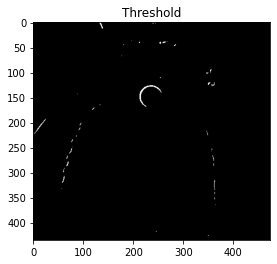

In [243]:
#ret, imgThreshold = cv2.threshold(grad, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret, imgThreshold = cv2.threshold(grad, 65, 255, cv2.THRESH_BINARY)
#cv2.thre
print(ret)
plt.imshow(imgThreshold)
plt.title("Threshold")
plt.show()


### Detecção de linhas

In [244]:
# lines = cv2.HoughLinesP(image: Mat, rho, theta, threshold, minLineLength=..., maxLineGap=...) 
lines = cv2.HoughLinesP(imgThreshold, rho=1, theta=np.pi/180, threshold=60, minLineLength=3,maxLineGap=1)

try:
    if(lines.any != None):
        print(len(lines[0]))

        for line in lines:
            x1, y1, x2, y2 = line[0]
            #print(line[0])
            cv2.line(image, (x1, y1), (x2, y2), (255,0,0),4)
        plt.imshow(image)
        plt.title("Transformada de Hough")
        plt.show()
except:
    print("Nenhuma linha foi identificada nesta imagem")

Nenhuma linha foi identificada nesta imagem


### Detecção de círculos